In [8]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.13.1


# Configuration

In [12]:
#dataset
#https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
input_directory = "chest_xray/"
training_dir = input_directory + "train"
validation_dir = input_directory + "val"
testing_dir = input_directory + "test"

In [11]:
positive_class = "PNEUMONIA"
negative_class = "NORMAL"

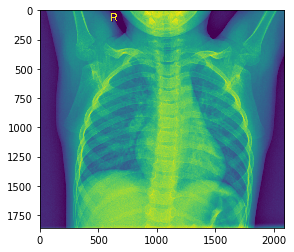

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#NORMAL example
img1 = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img1)
plt.show()

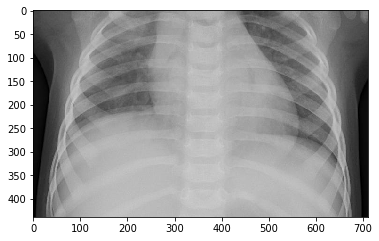

In [5]:
#PNEUMONIA example
img2 = mpimg.imread(training_dir + '/PNEUMONIA/person1_bacteria_1.jpeg')
imgplot = plt.imshow(img2)
plt.show()

# Preprocessing

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(featurewise_center = True,
                                     shear_range = 0.2,
                                     rescale = 1.0/255,
                                     horizontal_flip = True,
                                     validation_split = 0.2)

test_generator = ImageDataGenerator(rescale = 1.0/255)

In [15]:
train_iterator = train_generator.flow_from_directory(training_dir, 
                                                     target_size = (150, 150),
                                                     classes = [positive_class, negative_class],
                                                     batch_size = 256, 
                                                     shuffle = True, 
                                                     class_mode = "binary",
                                                     subset = "training")
                                                    
validation_iterator = train_generator.flow_from_directory(training_dir, 
                                                          target_size = (150, 150),
                                                          classes = [positive_class, negative_class],
                                                          batch_size = 128, 
                                                          shuffle = False, 
                                                          class_mode = "binary",
                                                          subset = "validation")

test_iterator = test_generator.flow_from_directory(testing_dir, 
                                                   target_size = (150, 150), 
                                                   classes = [positive_class, negative_class],
                                                   batch_size = 64, 
                                                   shuffle = False,
                                                   class_mode = "binary")

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
from IPython.display import clear_output
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

clear_session()

base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
clear_output()

base_model.trainable = False
model = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation = "relu"),
                      Dropout(0.3),
                      Dense(512, activation = "relu"),
                      Dropout(0.3),
                      Dense(256, activation = "relu"),
                      Dropout(0.3),
                      Dense(128, activation = "relu"),
                      Dropout(0.3),
                      Dense(1, activation = "sigmoid")])

model.compile(RMSprop(), loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np;

y = train_iterator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight("balanced", labels, y)
train_class_weights

array([0.67306452, 1.944548  ])

# Training model

In [22]:
model.fit_generator(train_iterator, 
                                steps_per_epoch = len(train_iterator),
                                epochs = 10,
                                verbose = 1,
                                workers = 20,
                                validation_data = validation_iterator, 
                                validation_steps = len(validation_iterator),
                                class_weight = train_class_weights)

D:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
Instructions for updating:
Use tf.cast instead.
17/17 [==============================] - 571s 34s/step - loss: 1.2819 - acc: 0.6657 - val_loss: 2.3554 - val_acc: 0.2570
Epoch 2/10
17/17 [==============================] - 351s 21s/step - loss: 0.4832 - acc: 0.7549 - val_loss: 0.9415 - val_acc: 0.3586
Epoch 3/10
17/17 [==============================] - 384s 23s/step - loss: 0.3704 - acc: 0.8258 - val_loss: 0.9615 - val_acc: 0.4151
Epoch 4/10
17/17 [==============================] - 409s 24s/step - loss: 0.3354 - acc: 0.8495 - val_loss: 0.5942 - val_acc: 0.8495
Epoch 5/10
17/17 [==============================] - 384s 23s/step - loss: 0.3279 - acc: 0.8708 - val_loss: 0.3221 - val_acc: 0.8869
Epoch 6/10
17/17 [==============================] - 352s 21s/step - loss: 0.3399 - acc: 0.8797 - val_loss: 0.5206 - val_acc: 0.8274
Epoch 7/10
17/17 [==============================] - 370s 22s/step - loss: 0.2404 - acc: 0.9053 - val_loss: 1.8466 - val_acc: 0.7852
Epoch 8/10
17/17 [==========

In [36]:
from sklearn.metrics import classification_report
y_pred = model.predict_generator(test_iterator,
                                 steps = len(test_iterator),
                                 verbose = 0)  
mask = y_pred > 0.5
y_pred[mask] = 1
y_pred[~mask] = 0
y_ture = test_iterator.classes
target_names = [positive_class, negative_class]
print(classification_report(y_ture, y_pred, target_names = target_names))

              precision    recall  f1-score   support

   PNEUMONIA       0.67      0.99      0.80       390
      NORMAL       0.95      0.17      0.29       234

   micro avg       0.69      0.69      0.69       624
   macro avg       0.81      0.58      0.54       624
weighted avg       0.77      0.69      0.61       624



In [32]:
save_model(myModel, "./savedmodel", overwrite = True, include_optimizer = True)

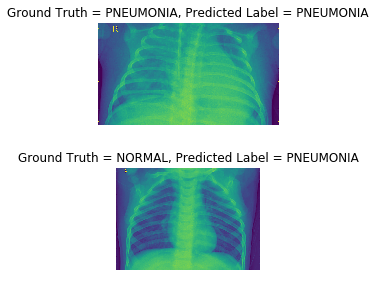

In [40]:
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

label_dict = {0:"PNEUMONIA", 1:"NORMAL"}
test_file_names = test_iterator.filenames
n = len(test_file_names)
plt.rcParams["figure.figsize"] = 12, 10

for i in range(2):
    index = randint(0, n - 1)
    file_name = testing_dir + '/' + test_file_names[index]
    
    #image = cv2.imread(file_name, cv2.IMREAD_COLOR)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = mpimg.imread(file_name)
    
    ground_truth_label = label_dict[int(y[index])]
    predicted_label = label_dict[int(yhat[index])]
    
    plt.subplot(5, 1, i + 1)
    plt.axis("off")
    plt.imshow(image)
    
    title = "Ground Truth = " + ground_truth_label + ", Predicted Label = " + predicted_label
    plt.title(title)

plt.tight_layout()
plt.show()